# Topic Modeling with Amortized LDA

In this tutorial, we will explore how to run the amortized Latent Dirichlet Allocation (LDA) model implementation in scvi-tools. LDA is a topic modelling method first introduced in the natural language processing field. By treating each cell as a document and each gene expression count as a word, we can carry over the method to the single-cell biology field.

Below, we will train the model over a dataset, plot the topics over a UMAP of the reference set, and inspect the topics for characteristic gene sets.

As an example, we use the PBMC 10K dataset from 10x Genomics.

In [ ]:
!pip install --quiet scvi-colab
from scvi_colab import install

install()

In [1]:
import os

import pandas as pd
import scanpy as sc
import scvi

/home/adam/Documents/software/scvi-tools/scvi/_settings.py:158: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  warnings.warn(
/home/adam/miniconda3/envs/scvi-tools-dev/lib/python3.10/site-packages/flax/core/frozen_dict.py:169: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(


In [2]:
sc.set_figure_params(figsize=(4, 4))

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

## Load and process data

Load the 10x genomics PBMC dataset. Generally, it is good practice for LDA to remove ubiquitous genes, to prevent the model from modeling these genes as a separate topic. Here, we first filter out all mitochrondrial genes, then select the top 1000 variable genes with seurat_v3 method from the remaining genes.

In [3]:
save_path = "data"
adata = sc.read(
    os.path.join(save_path, "pbmc_10k_protein_v3.h5ad"),
    backup_url="https://github.com/YosefLab/scVI-data/raw/master/pbmc_10k_protein_v3.h5ad?raw=true",
)

adata.layers["counts"] = adata.X.copy()  # preserve counts
sc.pp.normalize_total(adata, target_sum=10e4)
sc.pp.log1p(adata)
adata.raw = adata  # freeze the state in `.raw`

adata = adata[:, ~adata.var_names.str.startswith("MT-")]
sc.pp.highly_variable_genes(
    adata, flavor="seurat_v3", layer="counts", n_top_genes=1000, subset=True
)

/home/adam/miniconda3/envs/scvi-tools-dev/lib/python3.10/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


## Create and fit `AmortizedLDA` model

Here, we initialize and fit an `AmortizedLDA` model on the dataset. We pick 10 topics to model in this case.

In [4]:
n_topics = 10

scvi.model.AmortizedLDA.setup_anndata(adata, layer="counts")
model = scvi.model.AmortizedLDA(adata, n_topics=n_topics)

```{note}
By default we train with KL annealing which means the effective loss will generally not decrease steadily in the beginning. Our Pyro implementations present this train loss term as the `elbo_train` in the progress bar which is misleading. We plan on correcting this in the future.
```

In [5]:
model.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/adam/miniconda3/envs/scvi-tools-dev/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1000/1000: 100%|██████████| 1000/1000 [06:01<00:00,  2.85it/s, v_num=1, elbo_train=1.84e+7]

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 1000/1000: 100%|██████████| 1000/1000 [06:01<00:00,  2.76it/s, v_num=1, elbo_train=1.84e+7]


## Visualizing learned topics

By calling `model.get_latent_representation()`, the model will compute a Monte Carlo estimate of the topic proportions for each cell. Since we use a logistic-Normal distribution to approximate the Dirichlet distribution, the model cannot compute the analytic mean. The number of samples used to compute the latent representation can be configured with the optional argument `n_samples`.

In [6]:
topic_prop = model.get_latent_representation()
topic_prop.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
index,,,,,,,,,,
AAACCCAAGATTGTGA-1,0.000140,0.000091,0.000370,0.004209,0.000192,0.757920,0.236237,0.000104,0.000217,0.000519
AAACCCACATCGGTTA-1,0.000160,0.000183,0.000105,0.005576,0.000126,0.957939,0.017213,0.000168,0.000186,0.018343
AAACCCAGTACCGCGT-1,0.000474,0.002273,0.006529,0.001293,0.001002,0.550447,0.431790,0.000396,0.000861,0.004936
AAACCCAGTATCGAAA-1,0.984710,0.004950,0.001520,0.001724,0.001361,0.000984,0.001483,0.000960,0.001237,0.001071
AAACCCAGTCGTCATA-1,0.995573,0.000500,0.000265,0.000235,0.000245,0.000262,0.000278,0.000118,0.000163,0.002360


In [7]:
# Save topic proportions in obsm and obs columns.
adata.obsm["X_LDA"] = topic_prop
for i in range(n_topics):
    adata.obs[f"LDA_topic_{i}"] = topic_prop[[f"topic_{i}"]]

### Plot UMAP

In [8]:
sc.tl.pca(adata, svd_solver="arpack")
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=20)
sc.tl.umap(adata)
sc.tl.leiden(adata, key_added="leiden_scVI", resolution=0.8)

# Save UMAP to custom .obsm field.
adata.obsm["raw_counts_umap"] = adata.obsm["X_umap"].copy()

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


/home/adam/miniconda3/envs/scvi-tools-dev/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


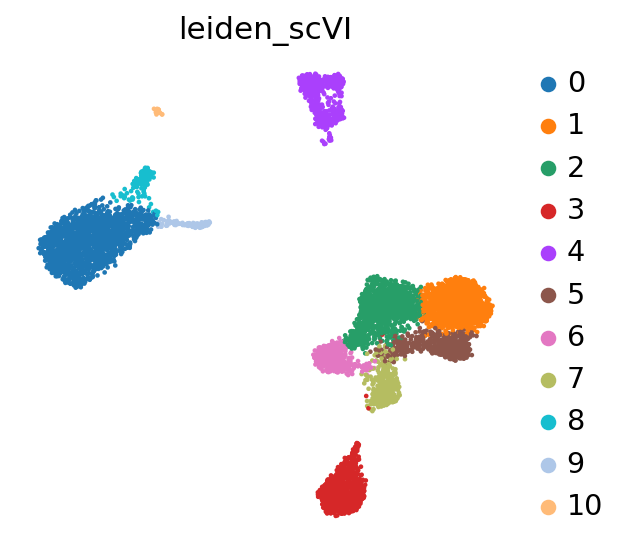

In [9]:
sc.pl.embedding(adata, "raw_counts_umap", color=["leiden_scVI"], frameon=False)

### Color UMAP by topic proportions

By coloring by UMAP by topic proportions, we find that the learned topics are generally dominant in cells close together in the UMAP space. In some cases, a topic is dominant in multiple clusters in the UMAP, which indicates similarilty between these clusters despite being far apart in the plot. This is not surprising considering that UMAP does not preserve local relationships beyond a certain threshold.

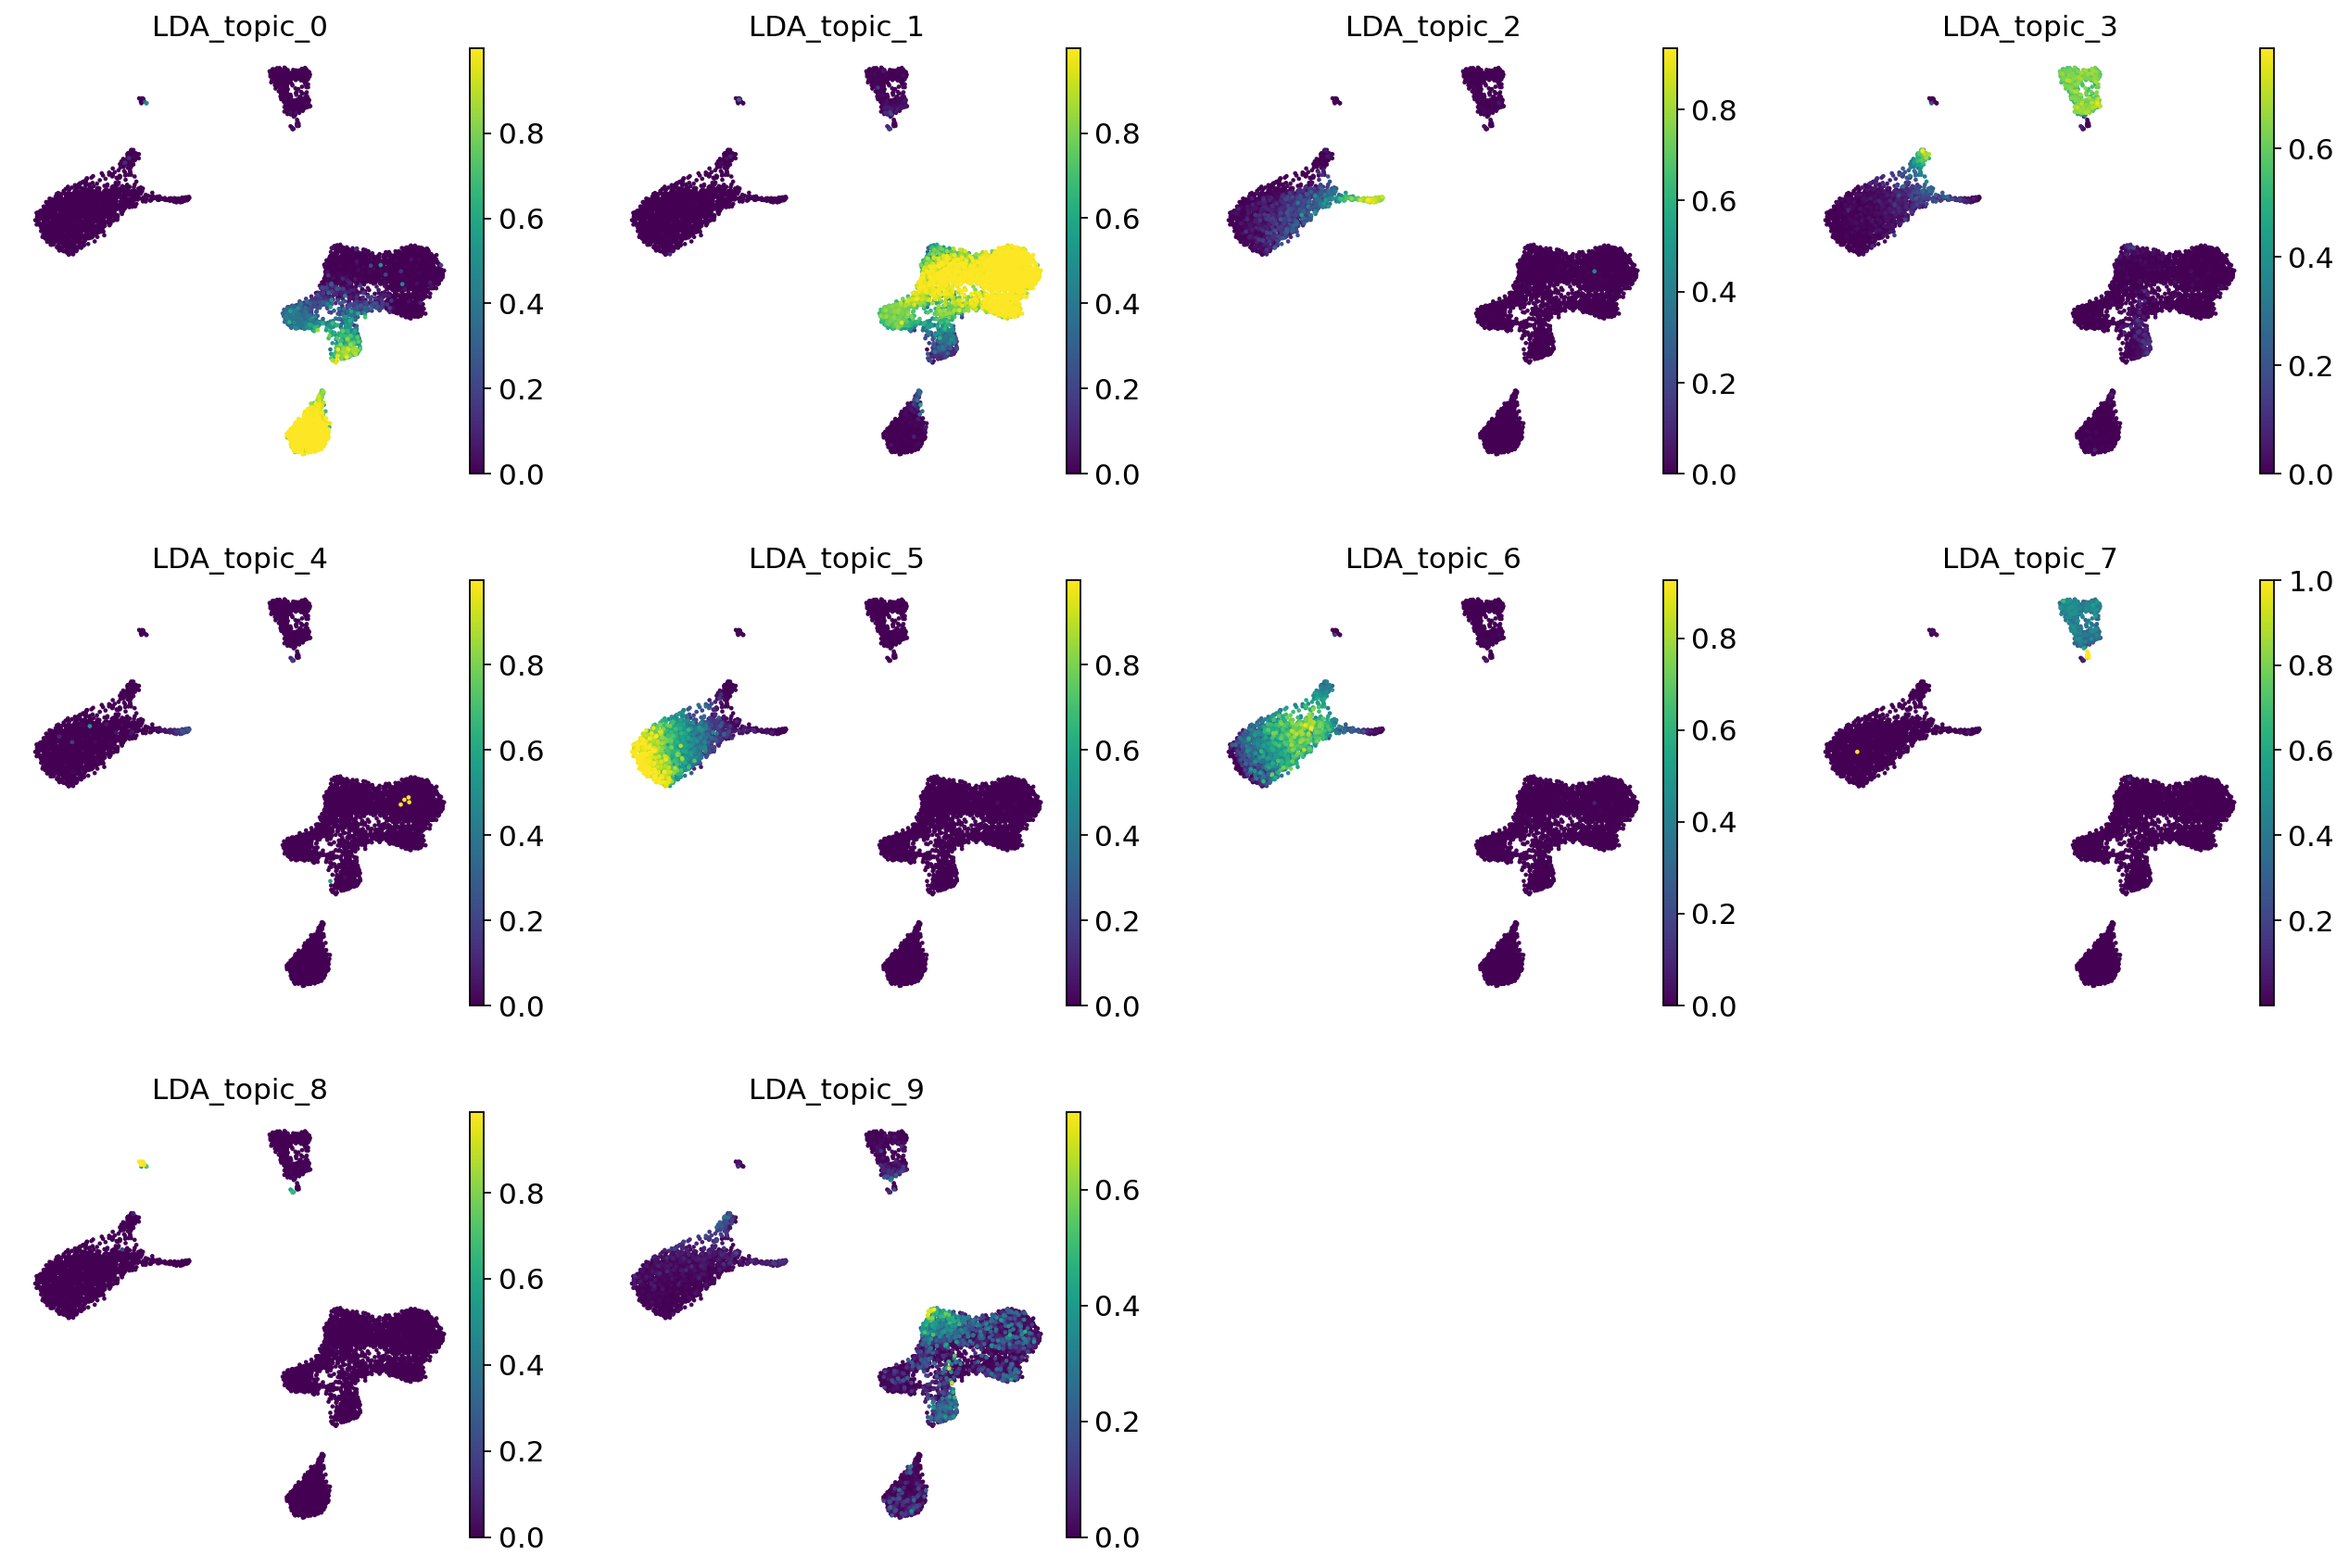

In [10]:
sc.pl.embedding(
    adata,
    "raw_counts_umap",
    color=[f"LDA_topic_{i}" for i in range(n_topics)],
    frameon=False,
)

### Plot UMAP in topic space

In [11]:
sc.pp.neighbors(adata, use_rep="X_LDA", n_neighbors=20, metric="hellinger")
sc.tl.umap(adata)

# Save UMAP to custom .obsm field.
adata.obsm["topic_space_umap"] = adata.obsm["X_umap"].copy()

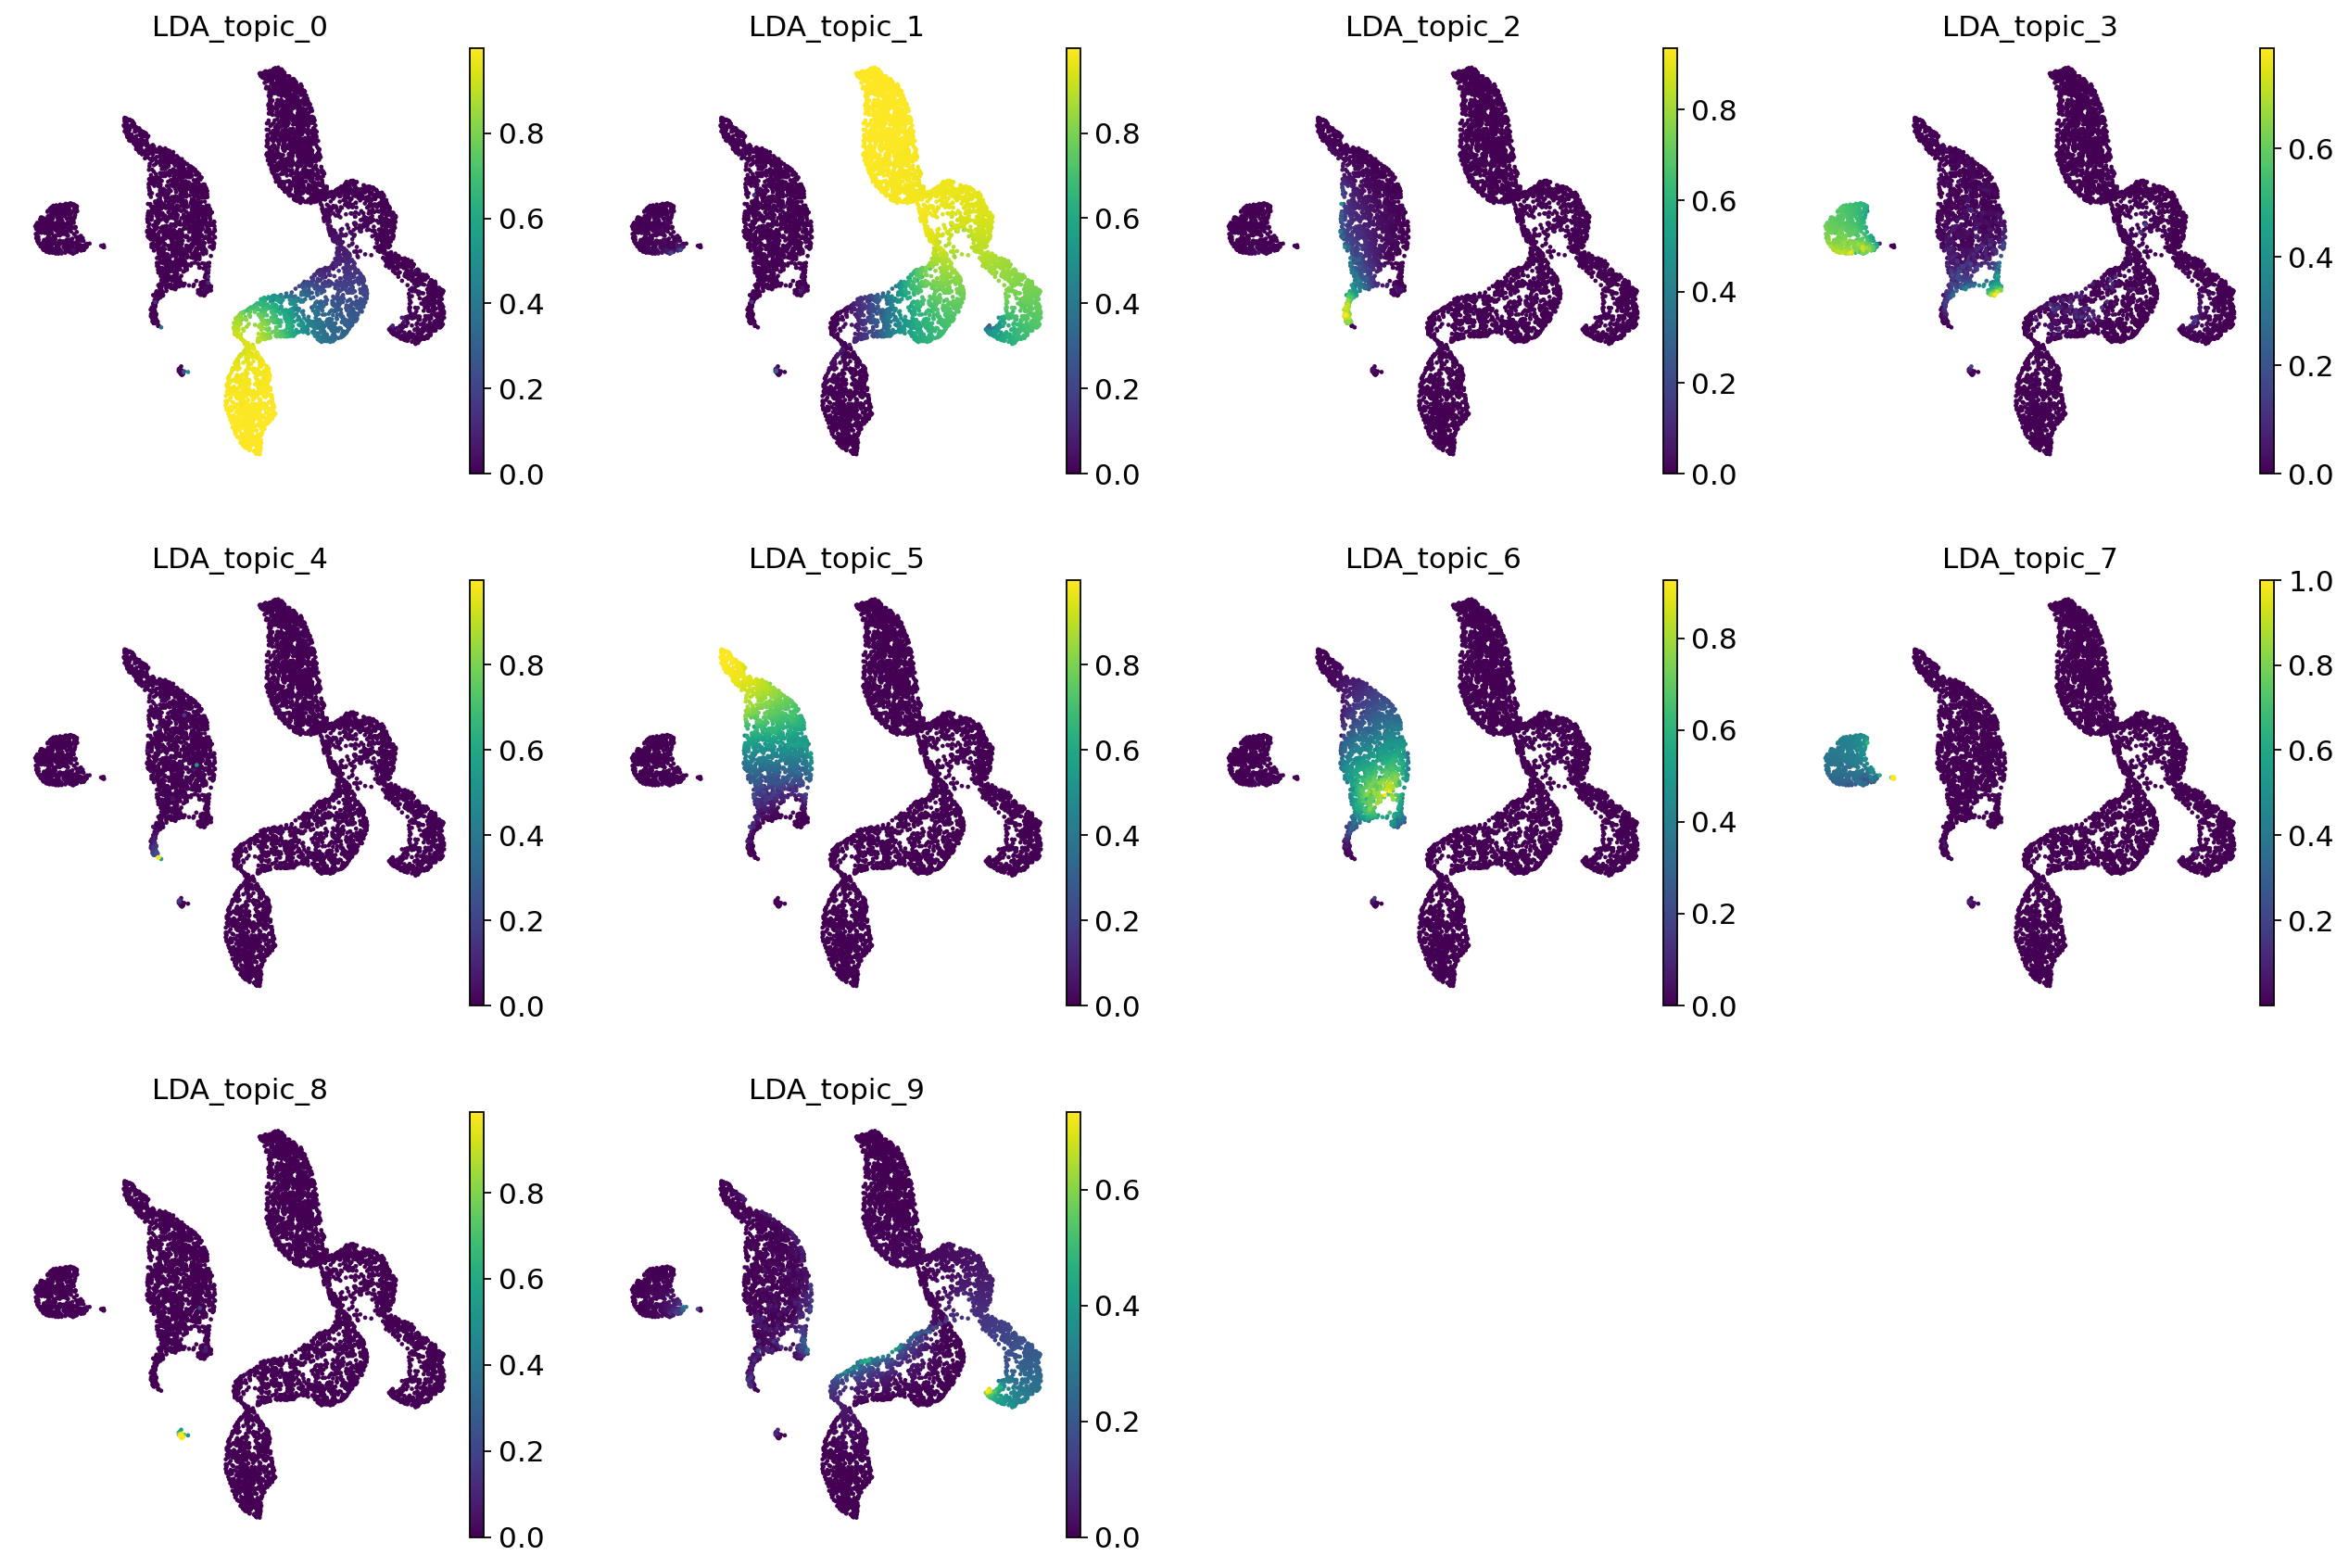

In [12]:
sc.pl.embedding(
    adata,
    "topic_space_umap",
    color=[f"LDA_topic_{i}" for i in range(n_topics)],
    frameon=False,
)

### Find top genes per topic

Similar to the topic proportions, `model.get_feature_by_topic()` returns a Monte Carlo estimate of the gene by topic matrix, which contains the proportion that a gene is weighted in each topic. This is also due to another approximation of the Dirichlet with a logistic-Normal distribution. We can inspect each topic in this matrix and sort by proportion allocated to each gene to determine top genes characterizing each topic.

In [13]:
feature_by_topic = model.get_feature_by_topic()
feature_by_topic.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
index,,,,,,,,,,
AL645608.8,0.000002,0.000001,0.000014,0.000002,0.000140,4.226326e-06,0.000001,0.000005,0.000018,0.000004
HES4,0.000007,0.000005,0.000153,0.000010,0.004792,6.340905e-06,0.000005,0.000007,0.000026,0.000007
ISG15,0.001345,0.001193,0.001350,0.000300,0.000057,2.926238e-04,0.000223,0.000307,0.000039,0.001298
TNFRSF18,0.000133,0.000423,0.000003,0.000005,0.000035,8.482926e-07,0.000001,0.000064,0.000089,0.000019
TNFRSF4,0.000059,0.000831,0.000003,0.000004,0.000031,1.750126e-06,0.000002,0.000007,0.000037,0.000022


In [14]:
rank_by_topic = pd.DataFrame()
for i in range(n_topics):
    topic_name = f"topic_{i}"
    topic = feature_by_topic[topic_name].sort_values(ascending=False)
    rank_by_topic[topic_name] = topic.index
    rank_by_topic[f"{topic_name}_prop"] = topic.values

In [15]:
rank_by_topic.head()

,topic_0,topic_0_prop,topic_1,topic_1_prop,topic_2,topic_2_prop,topic_3,topic_3_prop,topic_4,topic_4_prop,topic_5,topic_5_prop,topic_6,topic_6_prop,topic_7,topic_7_prop,topic_8,topic_8_prop,topic_9,topic_9_prop
0,TMSB4X,0.087940,TMSB4X,0.128904,FTL,0.121524,CD74,0.151225,TMSB4X,0.099046,S100A9,0.144305,LYZ,0.074579,IGKC,0.222961,CD74,0.075236,ACTB,0.277791
1,ACTB,0.085636,TMSB10,0.086715,FTH1,0.070623,HLA-DRA,0.118559,ACTB,0.088994,S100A8,0.099209,FTH1,0.052626,IGLC2,0.122605,ACTB,0.040889,TMSB4X,0.114209
2,GNLY,0.070562,ACTB,0.077280,ACTB,0.058146,HLA-DRB1,0.069039,FTH1,0.032347,LYZ,0.052620,FTL,0.042102,IGHA1,0.078818,HLA-DRA,0.029397,ACTG1,0.089032
3,NKG7,0.054295,JUNB,0.034678,TMSB4X,0.055765,TMSB4X,0.061284,H3F3A,0.031736,FTL,0.045681,ACTB,0.032262,IGHM,0.055276,TMSB4X,0.026814,TMSB10,0.077840
4,CCL5,0.041439,FTH1,0.028662,S100A4,0.030253,ACTB,0.048254,CDKN1C,0.029134,ACTB,0.036801,TMSB4X,0.029318,IGLC3,0.037869,FTH1,0.025850,S100A4,0.051337
